# Práctica 3: BMV VS VOLKSWAGEN
### _Guillermo González Díaz_
#### Noviembre de 2021

## Preguntas a respponder:
Utilizando datos diarios de yahoo de los dos series (yfinance), debemos analizar la relación entre BMW (BMW.DE) y Volkswagen(VOW.DE), contestando a las siguiente preguntas:
1. Estima un modelo VAR mensual entre los dos activos.  **(Muestra:2009/01 a 2020/10)**
2. ¿Cuál es la predicción para octubre de 2021 de los dos activos?. ¿Son buenas predicciones?
3. ¿Cuál de los dos activos es el lider y cual es el seguidor? Cual explica a cual vaya
4. ¿Es la Volatilidad de BMW constante? Estimar el modelo garch de BMW
(Muestra: Toda la disponible en Yahoo hasta el 31/10/2020)
5. ¿Cuál es la predicción para el mes de noviembre de 2020? ¿Son buenas predicciones?
6. Plantea un sistema de trading diario para BMW apartir del modelo Garch para el mes de noviembre de 2020. ¿Es rentable? Esto quiere decir que con la volatilidad plantear modelos de inversión

In [189]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from matplotlib.pyplot import *
import statsmodels.formula.api as smf
from sktime.utils.plotting import plot_correlations
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from arch.univariate import ARX
from arch.univariate import ARCH, GARCH
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.base.datetools import dates_from_str

In [190]:
# Importamos la libreria de gráficos Seaborn, coge los datos de esa librería
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 5)})

## 1. Carga y visualización de nuestros datos:

In [191]:
# Seleccionamos las dos empresas que queremos
tickers = ["BMW.DE", "VOW.DE"]
start = dt.datetime(2009, 1, 1)
end = dt.datetime(2020, 11, 1)

In [192]:
# Nuestros datos. 
tickers = ["BMW.DE", "VOW.DE"]
start = dt.datetime(2009, 1, 1)
end = dt.datetime(2020, 10, 30)

stocks = yf.download(tickers,
                     start = start,
                     end = end, interval="1mo")

[*********************100%***********************]  2 of 2 completed


In [193]:
# Nos quedamos con la columna que nos interesa
stocks = stocks['Adj Close']

In [194]:
# Separamos bmw de volkswagen
bmw = pd.DataFrame(stocks['BMW.DE'])
vk = pd.DataFrame(stocks['VOW.DE'])

En este caso solo nos interesan los datos de cierre ajustado, por eso creamos un Data Frame con las dos series en el preíodo comprendido entre enero de 2009 y octubre de 2020, ambos incluidos.

In [195]:
# eliminamos los nas
stocks = stocks.dropna()

Nos quedamos solamente don el _precio ajustado_, que es el que nos interesa

In [197]:
bmw = pd.DataFrame(stocks['BMW.DE'])
vk = pd.DataFrame(stocks['VOW.DE'])

Visualizamos nuestra serie temporal conjunta y comentamos Volkswagen aparte. Podemos observar que las dos llevan una tendencia parecida, creciendo después de la crisisi de 2009 hasta el momento del escándalo de las emisiones, y después una recuperación constante hasta la siguiente gran caída, el año pasado, causada por el covid.

<AxesSubplot:xlabel='Date'>

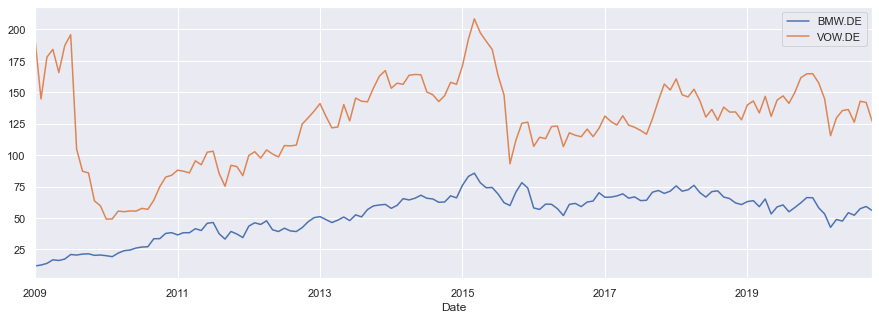

In [198]:
stocks.plot()

Mirando Volkswagen para ver mejor los tres momentos críticos de los que hablábamos antes. Es especialmente llamativa la caída de 2009 y la provocada por la estafa de las emisiones, mucho más drásticas que la del año pasado. Aquí el gráfico:

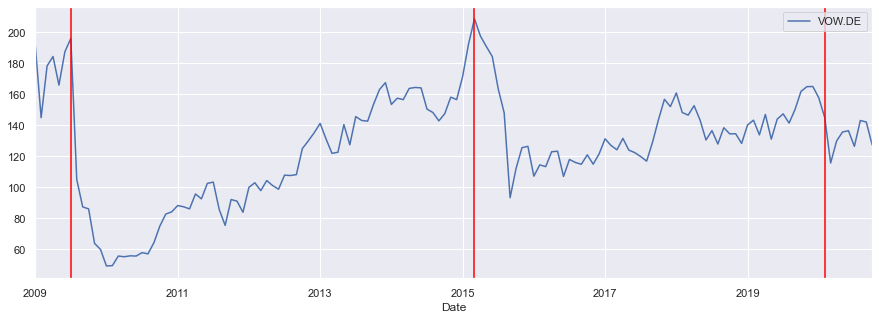

In [199]:
vk.plot()
plt.axvline(x=('2015-03-01'), color = "red", )
plt.axvline(x=('2009-07-01'), color = "red", )
plt.axvline(x=('2020-02-01'), color = "red", )
plt.show();

Calculamos los retornos logarítmicos y visualizamos nuevamente las series:

In [ ]:
stocks.head

In [173]:
stocks_ret = np.log(stocks).diff().dropna()
stocks_ret = stocks_ret.rename(columns={'BMW.DE': 'bmw_ret', 'VOW.DE': 'vk_ret'})
stocks_ret

,bmw_ret,vk_ret
Date,,
2009-02-01,0.059454,-0.282817
2009-03-01,0.098298,0.207274
2009-04-01,0.186215,0.033710
2009-05-01,-0.033114,-0.105416
2009-06-01,0.067534,0.121788
...,...,...
2020-06-01,0.131735,0.006300
2020-07-01,-0.038025,-0.076849
2020-08-01,0.094978,0.123877


In [ ]:
bmw_ret = pd.DataFrame(stocks_ret['bmw_ret'])
vk_ret = pd.DataFrame(stocks_ret['vk_ret'])

<AxesSubplot:xlabel='Date'>

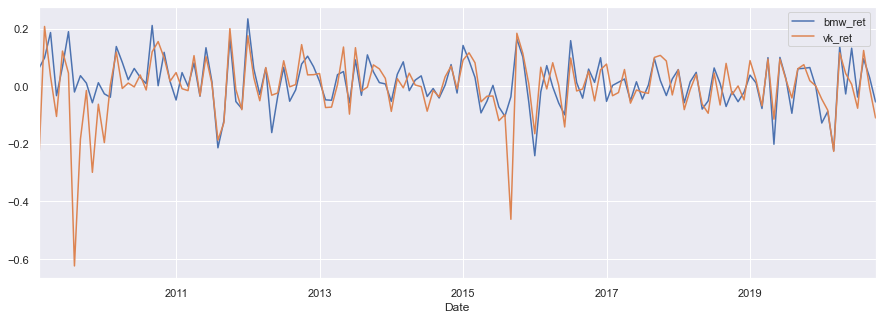

In [174]:
stocks_ret.plot()

## Autocorrelación:
A continuación pasamos a visualizar si existe autocorrelación parcial en nuestras dos series. En las dos solamente existe un período que sea significativo y pueda explicar el actual, por lo tanto podemos decir que no existe autocorrelación en ambas series. Vemos que estas dos series son estacionarias en sus retornos, por eso a continuación pasaremos a realizar un modelo VAR

/Users/guillemrogonzalezdiaz/miniconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


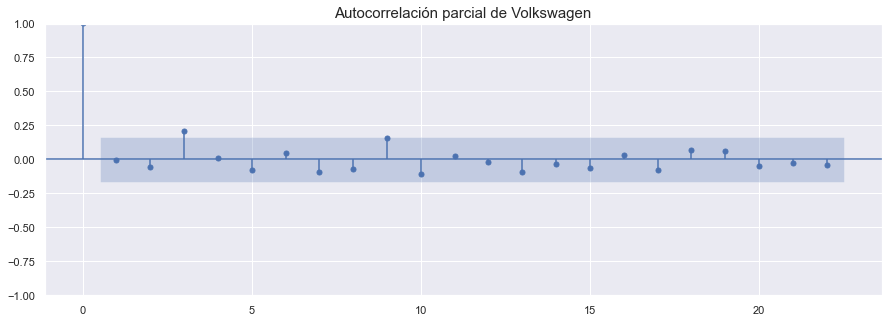

In [175]:
plot_pacf(vk_ret)
plt.title('Autocorrelación parcial de Volkswagen', fontsize = 15)
plt.show()

/Users/guillemrogonzalezdiaz/miniconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


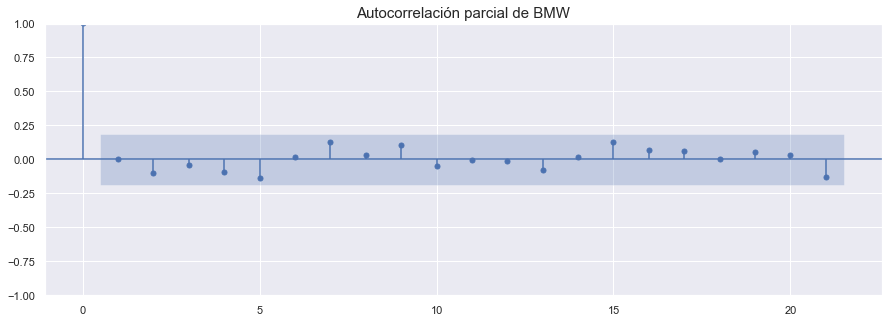

In [176]:
plot_pacf(bmw_ret)
plt.title('Autocorrelación parcial de BMW', fontsize = 15)
plt.show()

## 2. Causalidad
¿ Quién sigue a quién ?

Intentando contestar a la pregunta que se nos realiza, analizamos los siguientes resultados. Hemos realizado un test de Granger, que nos dice si una serie temporal viene causada por otra. En la línea de código, la que introducimos primero es la que explica a la que introducimos en segundo lugar. Tenemos que fijarnos en el p valor, si nos encontráramos con un p valor muy bajo, podríamos decir que la primera serie explica, o provoca algún efecto en la segunda.

Primero comentamos a BMW, que parece no explicar a Volkswagen en ninguno de los períodos. Hemos puesto 13 lags para ver un año entero más un mes, ya que enero-enero(-1) podrían estar relacionados.

Después, viendo Volkswagen como líder vemos que tampoco existe causalidad. He probado con hasta 13 retardos para comparar poco más de un año y en ningún momento he detectado esa correlación, por lo tanto dejo un lag de 3 para que sirva como ejemplo. Visualizamos los resultados del primero:

*Test de causalidad de Granger:*

In [ ]:
gc_res = grangercausalitytests(stocks_ret[['bmw_ret','vk_ret']], 3)

In [ ]:
grangercausalitytests(stocks_ret[['vk_ret','bmw_ret']], 3)

## 3. Modelo VAR
Realizamos una selección de VAR automática y vemos que nos arroja un modelo con dos ecuaciones. Hemos vuelto a usar el máximo de lags para que tenga todo ese período en cuenta.


Este sería un ejemplo de VAR 1 model porque sólo nos interesa un momento del pasado, si queremos más períodos las ecuaciones se complican más. Usamos vectores para estas fórmulas.

Hacemos el VAR sobre los retornos puesto que los precios no son estacionarios. Este es nuestro modelo:


Rápida explicación: ahora tenemos dos variables, nos habíamos centrado anteriormente en una. 
Tenemos, por ejemplo, manzanas y plátanos. Tenemos ventas de manzanas y de plátanos este mes y el mes del período anterior, t-1. El número de cada uno que vendí el período anterior, puede afectar a este. 

Lo interesante de estos modelos es que, también la venta de manzanas del mes anterior puede afectar a la venta de plátanos de este mes. También viceversa. 

#### Ecuación: at = C11 * At-1 + C12 * bt-1 + Ea1t
#### Siendo: at ventas de manzanas de este mes, c11 y c12 dos coeficientes, at-1 venta de manzanas del periodo anterior y bt-1 venta de plátanos del período anterior. E es el error en el número de manzanas que vendo este mes.

Por lo tanto vemos cómo la venta de manzanas de hoy está influenciada por la de ayer + la de plátanos de ayer. Para plátanos, sería similar. Ref: https://www.youtube.com/watch?v=UQQHSbeIaB0

In [177]:
# Creamos un buble para que, durante 13 meses, nos devuelva las correlaciones entre bmw y 
# volkswagen lageado todos esos periodos.  El primer vaor es la correlación, y el segundo
# es el p value. Como vemos, no hay ninguno significativo. Solamente quizás el 13, que sería
# el primer valor significante. Por eso usaremos 13 lags a continuación.
for lag in range(1, 14):
    # definimos que es bmw y que es vk lageado:
    bmw_ret = stocks_ret['bmw_ret'].iloc[lag:]
    lagged_vk = stocks_ret['vk_ret'].iloc[:-lag]
    # imprimimos coeficientes
    print('Lag: %s' %lag)
    print(pearsonr(bmw_ret, lagged_vk))
    print('---------')

Lag: 1
(-0.10532200228458208, 0.21554488707237807)
---------
Lag: 2
(-0.15964321524420305, 0.06048692226079118)
---------
Lag: 3
(0.09777619377603182, 0.25391213347028563)
---------
Lag: 4
(-0.0026264701183304827, 0.9756998607270375)
---------
Lag: 5
(-0.06795109434611929, 0.43184769288404945)
---------
Lag: 6
(-0.04333048413989514, 0.6177740260250563)
---------
Lag: 7
(-0.14014040369053019, 0.1063053646410847)
---------
Lag: 8
(-0.04997099581017629, 0.5678567415931491)
---------
Lag: 9
(0.22779817481237255, 0.008615626456756877)
---------
Lag: 10
(-0.19633412781346757, 0.024606079804543154)
---------
Lag: 11
(-0.12031658278504762, 0.17271566329685442)
---------
Lag: 12
(0.07933544905558752, 0.3714734931319477)
---------
Lag: 13
(-0.19418564817502595, 0.02806622912323659)
---------


In [ ]:
# Creamos la variable modelo, que va a ser un VAR de stocks.
# Como hay dos columnas, las trata como time series
model = VAR(stocks_ret)

In [ ]:
model_fit = model.fit(13, ic='aic')

In [ ]:
model_fit.summary()

**Residuos**
Comprobamos que los residuios de nuestro modelo se comportan como ruido blanco

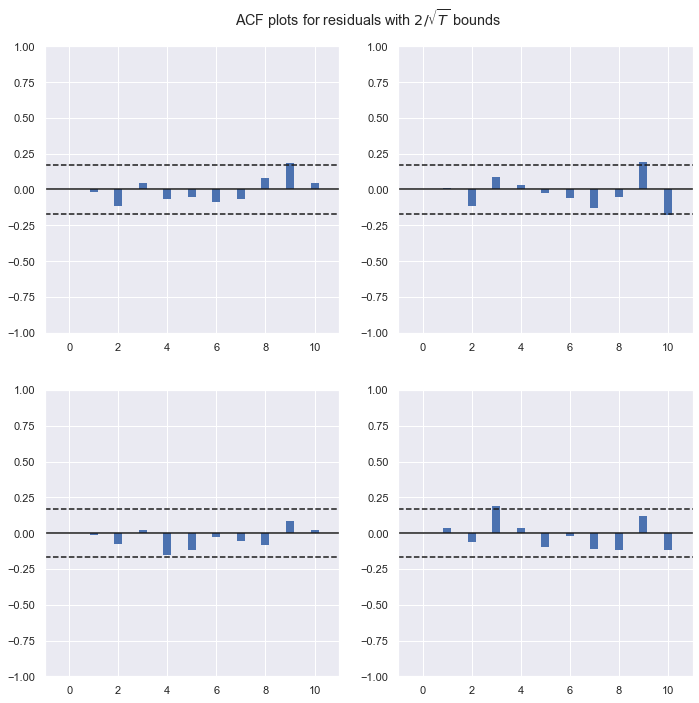

In [178]:
model_fit.plot_acorr();

## Predicciones: 
Realizamos las predicciones para octubre de 2020

In [179]:
lag = model_fit.k_ar

In [185]:
pred = model_fit.forecast(stocks_ret.values[-lag:], 13)

array([[ 0.01840177,  0.00028545],
       [ 0.01068881, -0.0011999 ],
       [ 0.01051888, -0.00087735],
       [ 0.01048084, -0.00086444],
       [ 0.01047805, -0.00086252],
       [ 0.01047775, -0.00086236],
       [ 0.01047772, -0.00086234],
       [ 0.01047772, -0.00086234],
       [ 0.01047772, -0.00086234],
       [ 0.01047772, -0.00086234],
       [ 0.01047772, -0.00086234],
       [ 0.01047772, -0.00086234],
       [ 0.01047772, -0.00086234]])

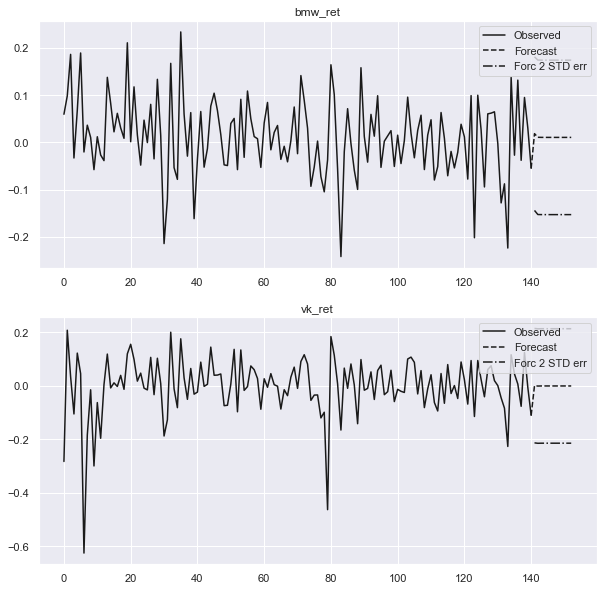

In [181]:
model_fit.plot_forecast(12);

In [ ]:
# Tenemos que tener en cuenta el último precio disponible:
vk_ultimo = stocks['VOW.DE'][-1]
bmw_ultimo = stocks['BMW.DE'][-1]

Predicción 12 periodos VOLKSWAGEN:

In [183]:
# Predicción 12 períodos, ya que nuestro último dato es octubre 2020:
pred_vk = (np.exp(np.cumsum(pred[:,1]))* vk_ultimo)
print(pred_vk)

[127.11838113 126.96594344 126.8545987  126.74498818 126.63571574
 126.52655736 126.4174951  126.30852703 126.19965291 126.09087264
 125.98218613 125.87359331 125.76509409]


Preidicción 12 periodos BMW

In [184]:
pred_bmw = (np.exp(np.cumsum(pred[:,0]))* bmw_ultimo)
print('Predicción 12 periodos:')
print(pred_bmw)         


Predicción 12 periodos:
[57.0693127  57.68258724 58.29254592 58.90671349 59.5271857  60.15417544
 60.7877675  61.4280329  62.07504207 62.72886605 63.38957664 64.05724635
 64.7319485 ]


### Comparamos nuestras predicciones con los valores reales:

Comparando ambas tablas, podemos ver que son predicciones bastante malas. Si bien es cierto que para BMW no tanto como para Volkswagen, podemos decir que no es un buen modelo y que no se ajusta bien. 

In [188]:
pred_oct = pd.DataFrame({'Predicción Octubre 2021': ['64.731', '125.765']}, index=['BMW.DE', 'VOW.DE'])
pred_oct

,Predicción Octubre 2021
BMW.DE,64.731
VOW.DE,125.765


**Valores reales de octubre de 2021**:

In [186]:
start_2021 = dt.datetime(2021, 1, 1)
end_2021 = dt.datetime(2021, 10, 30)

octubre_2021_real = yf.download(tickers,
                     start = start,
                     end = end_2021, 
                     interval="1mo")
octubre_2021_real = octubre_2021_real['Adj Close']
octubre_2021_real = octubre_2021_real.dropna()

[*********************100%***********************]  2 of 2 completed


In [187]:
real_oct = pd.DataFrame(octubre_2021_real.iloc[-1])
real_oct

,2021-10-01
BMW.DE,87.239998
VOW.DE,280.799988


### Respuesta del impulso:
Observamos que no provocan efectos mutuos:

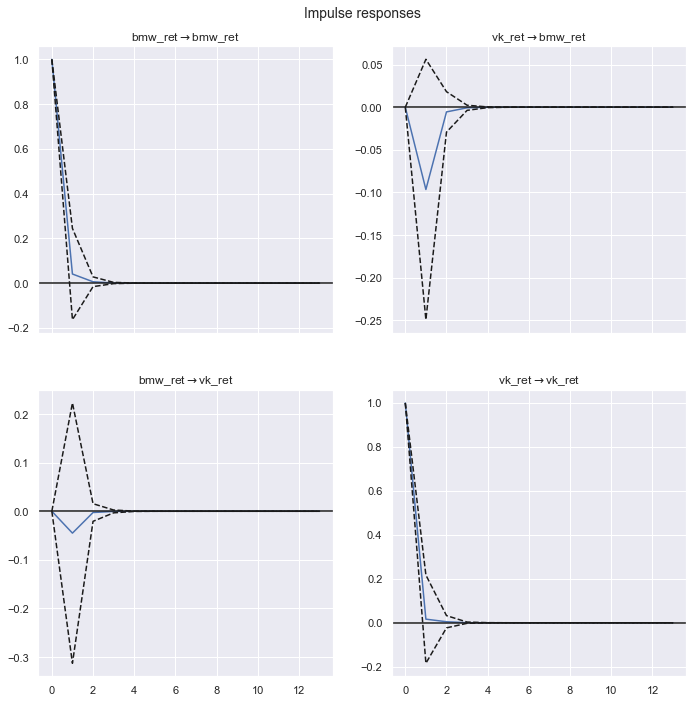

In [182]:
irf = model_fit.irf(13)
irf.plot(orth=False);

## 4. Volatilidad de BMW


En este apartado pasamos a analizar la volatilidad de bmw y a la realización de un modelo GARCH. Cogemos para ello los datos diarios del mismo período y los representamos:

In [ ]:
# Para este estudio cogemos la data diaria de BMW para el mismo periodo:
daily_bmw = yf.download('BMW.DE',
                     start = start,
                     end = end, interval="1d")
daily_bmw = pd.DataFrame(daily_bmw['Adj Close'])
daily_bmw

A continuación, calculamos los rendimientos con la tasa de variación logarítmica. Los representamos. Después calcumaos los rendimientos al cuadrado, que son una aproximación a la volatilidad.

In [ ]:
daily_bmw['log_ret'] = np.log(daily_bmw['Adj Close']).diff()
daily_bmw['rent_cuad'] = daily_bmw['log_ret']** 2
daily_bmw.tail()

Representación gráfica conjunta de precio, rentabilidad logarítmica y volatilidad:

In [ ]:
# Hemos separados los gráficos de precio, rentablidad logarítmica 
# y volatilidad. Podemos ver que existe cierta clusterización en la volatilidad,
# lo cual es un indicador de efecto garch.

plt.subplot(311)
ax = daily_bmw['Adj Close'].plot( linestyle='-')
ax.set_ylabel('Precio')
ax.set_xlabel('')
ax.set_title('BMW', y=1, fontsize = 16)

plt.subplot(312)
ax = daily_bmw['log_ret'].plot( linestyle='-')
ax.set_ylabel('Rentabilidad')
ax.set_xlabel('')
ax.set_title('Rentabilidad', y=0.8, x=0.6,fontsize = 16)

plt.subplot(313)
ax = daily_bmw['rent_cuad'].plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('Volatilidad', y=0.8, fontsize = 16)

In [ ]:
bmw_vol = pd.DataFrame(daily_bmw['rent_cuad'].astype('float64').to_period('D').sort_index().dropna())
bmw_vol = pd.rename
bmw_vol.tail()

**¿Hay autocorrelación?**

Podemos comprobar que sí existe correlación en la volatilidad de BMW, por lo tanto la z al cuadrado sigue teniendo comportamiento Garch, así que ste modelo no es adecuado para predecir. 

In [ ]:
plot_correlations(bmw_vol)

In [ ]:
# Comporbación numérica:
import statsmodels.api as sm
Ljung_Box = sm.stats.acorr_ljungbox 
Ljung_Box(bmw_vol, lags = 15, return_df=True)

Podemos ver que existe mucha autocorrelación en la volatilidad, pero de momento cogeremos un Garch 2, 2, puesto que a partir del segundo lag de alguna forma se ve que empieza a caer. Hay más momentos en los que existe autocorrelación, pero para mantenerlo siemple cogemos esos 2. 

(Veremos que al final para este trabajo nos decantamos por un Garch 1, 1, ya que al ver los resultados del 2,2 tuve que cambiarlo)

## 5. GARCH (1,1) BMW

In [ ]:
ar = ARX(100*daily_bmw['log_ret'].dropna(), lags = 365)
print(ar.fit().summary())

In [ ]:
# Recordemos que se tenía que cumplir que alfa1 y beta1 suamdos fueran menores a 1, y en este 
# caso estamos al límite, pues el resultado es 0.99. Alfa es el lag de la time series y
# omega de la volatilidad.
ar.volatility = GARCH(p=1 , q=1) # p siendo alfa, q omega
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

Visualizamos los resultados anualizados:
Podemos comprobar que esos clústeres que veíamos antes en la volatilidad de bmw se ha reducido bastante

In [ ]:
fig = res.plot(annualize="D")

Analizamos los residuos:
Igualmente ahora si existe ruido blanco en los residuios de BMW, no hay efecto GARCH.

In [ ]:
bmw_std_resid = (res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

In [ ]:
plot_correlations(bmw_std_resid)

Vamos a ver como se distribuyen los residuos. Vemos que se ajustan bastante a la recta, 
pero vamos a probar con T Student a ver si mejora.


In [ ]:
# Vamos a ver como se distribuyen los residuos. Vemos que se ajustan bastante a la recta, 
# pero vamos a probar con T Student a ver si mejora.
sm.qqplot(mod1_std_resid,line='45')
plt.show()

### T STUDENT:

In [ ]:
from arch.univariate import StudentsT

In [ ]:
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

Igual que antes, vemos los residuos gráficamente: 

Y comporbamos que siguen siendo ruido blanco

In [ ]:
bmw_std_resid= (res.resid / res.conditional_volatility).astype('float64').to_period('D').sort_index().dropna()

In [ ]:
plot_correlations(bmw_std_resid)

In [ ]:
plot_correlations(bmw_std_resid**2)

Vemos que se ajusta mucho mejor a la recta.

In [ ]:
from scipy import stats
sm.qqplot(bmw_std_resid, dist = stats.t,fit = True, line='45')
plt.show()

## 6. Forecast noviembre 2020

Por último hemos hecho una predicción para noviembre, como nuestro último valor era octubre de 2020 incluido, solo hemos tenido que especificar un horizonte de 30 días. Nuestro res viene de la última ejecución de la T de Student, así que es el modelo que estamos usando para predecir.

In [ ]:
forecasts = res.forecast(horizon = 30, reindex=False)
pd.DataFrame(forecasts.mean)

In [ ]:
# Lo pasamos al precio